# Objectives
In this Notebook, we will learn to train a semantic segmentation algorithm on a labeled data set in order to map on field image 3 classes: oilseed rape, other plants, soil.

After going through this notebook, you will be able to:
- Download an image dataset from Azure DataStore.
- Explore the class distribution from the labeled data.
- Create a training workflow for semantic segmentation algorithm.
- Create a ```Dataset``` class to feed data to computer vision models in PyTorch.
- Monitore output logs.
- Apply inference on the testing dataset.

# Set up

### Download the data

In [24]:
#Download data in the data folder
from azureml.core import Workspace, Dataset

subscription_id = '78b4d5f1-fca5-4af5-b686-34747c61c20f'
resource_group = 'ressource-group-Changins'
workspace_name = 'workspace-changins'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='oilseed-rape-dataset')
dataset.download(target_path='..//data/oilseed_rape', overwrite=True)

['/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-gpu-changins/code/Users/aurelie.dejong.agroscope/data/oilseed_rape/full_metrics.pt',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-gpu-changins/code/Users/aurelie.dejong.agroscope/data/oilseed_rape/test/Flowers/Images/cropped_190913_Pr_A_M07_2.JPG',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-gpu-changins/code/Users/aurelie.dejong.agroscope/data/oilseed_rape/test/Flowers/Masks/180926_Md_A_M05_3.jpg',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-gpu-changins/code/Users/aurelie.dejong.agroscope/data/oilseed_rape/test/Flowers/Masks/20200916_Ch_D_M03_2.jpg',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-gpu-changins/code/Users/aurelie.dejong.agroscope/data/oilseed_rape/test/Mixed/Images/cropped_180926_Md_A_M10_1.JPG',
 '/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-gpu-changins/code/Users/aurelie.dejong.agroscope/data/oilseed_rape/test/Mixed/Images/cropped_190913_Pr_D_M12_

### Imports

General imports

In [1]:
import cv2
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from tqdm import tqdm


import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms as T
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Custom imports from folder 'utils'.

In [2]:
from utils import plotImgs, plotLearning
from utils import TrainingDataset, InferenceDataset, Inference
from utils import my_confusion_matrix, cm2rates, rates2metrics

# Data Exploration

Before starting a model, it's always good have an overview of the data we work with. Especially, the class balance will be impacting the results. 

### Load the images and the masks

In [3]:
# Set the path to working directories
root = os.getcwd()
img_dir = root + '/../data/oilseed_rape/train/Images'
mask_dir = root + '/../data/oilseed_rape/train/Masks'

# Retrieve all the files in
img_paths = glob(img_dir + '/*')
mask_paths = glob(mask_dir + '/*')

In [4]:
img = cv2.cvtColor(cv2.imread(img_paths[1]), cv2.COLOR_BGR2RGB) # YOUR CODE HERE
mask = cv2.cvtColor(cv2.imread(mask_paths[1]), cv2.COLOR_BGR2RGB) # YOUR CODE HERE

print('Data type:', type(img))
print('')
print('Data size')
print('Mask ([ H, W, C]):', mask.shape)
print('Image ([H, W, C]):', img.shape)
print('')
print('Mask \n', mask[:4,:4])
print('')
print('Image \n', img[:4,:4])

Data type: <class 'numpy.ndarray'>

Data size
Mask ([ H, W, C]): (2820, 1680, 3)
Image ([H, W, C]): (2820, 1680, 3)

Mask 
 [[[255 255   0]
  [255 255   0]
  [255 255   0]
  [255 255   0]]

 [[255 255   0]
  [255 255   0]
  [255 255   0]
  [255 255   0]]

 [[255 255   0]
  [255 255   0]
  [255 255   0]
  [255 255   0]]

 [[255 255   0]
  [255 255   0]
  [255 255   0]
  [255 255   0]]]

Image 
 [[[ 83  98  59]
  [ 84  99  60]
  [ 84  99  60]
  [ 85 100  61]]

 [[ 86 101  62]
  [ 86 101  62]
  [ 86 101  62]
  [ 86 101  62]]

 [[ 89 101  63]
  [ 89 101  63]
  [ 89 101  63]
  [ 88 100  62]]

 [[ 87  99  61]
  [ 87  99  61]
  [ 87  99  61]
  [ 87  99  61]]]


### Visualize the image with its corresponding groundtruth mask.

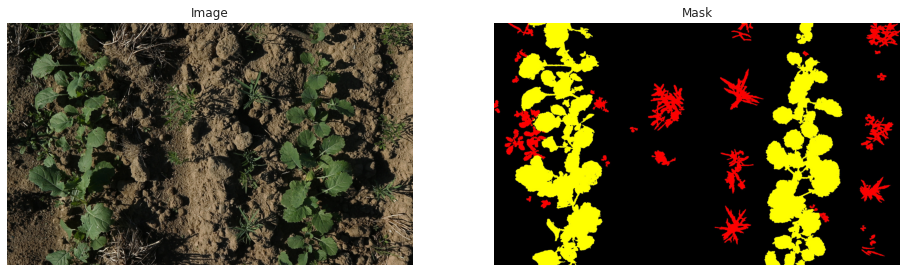

In [84]:
# A simple way to plot images
"""
plt.imshow(img)
plt.show()£
""" 

# Nice plots
plotImgs(1, 2, [img, mask], ['Image','Mask'])

### Class distribution

Retrieve information from the labeled data to check the class distribution in the dataset.

In [85]:
new_val = np.zeros((len(mask_paths),3))

for i, p in enumerate(mask_paths):
    mask = cv2.imread(p)
    #Create 3 classes, 0:BG, 1:SP, 2:OSR
    new_mask = np.zeros(mask.shape)
    new_mask[mask > 127] = 1              
    new_mask[new_mask[:, :, 1] > 0, 2] = 2
    class_mask = new_mask[:, :, 2].astype(int)

    # Get distribution per images
    size = class_mask.shape[0]*class_mask.shape[1]
    result = np.unique(class_mask, return_counts=True )
    new_val[i,result[0]] += np.round(100*result[1]/size,2)

In [86]:
df = pd.DataFrame(new_val, columns = ['Background', 'Other plants', 'Oilseed rape'])
df.head()

,Background,Other plants,Oilseed rape
0,60.92,0.23,38.85
1,77.76,5.00,17.25
2,80.77,5.83,13.40
3,90.69,1.93,7.38
4,30.33,11.99,57.68


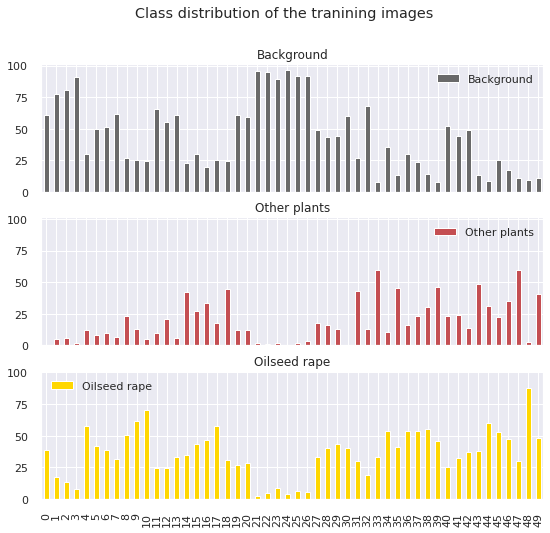

In [88]:
colors = ['dimgrey','r','gold']

df.plot.bar(subplots = True, figsize=(9, 8), color=colors,  sharey=True, title = 'Class distribution of the tranining images')
plt.show()

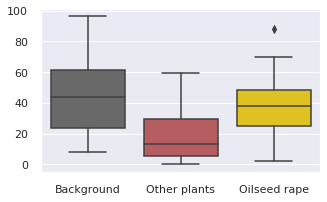

In [87]:
sns.set(rc={"figure.figsize":(5,3)}) 
sns.boxplot( data=df, palette = colors)
plt.show()

# Fine-tunning DeepLabv3+

### Dataset info
This class object permits to save usefull information for the training.

In [5]:
class DatasetInfo:
    """ Class used to define all parameters and methods specific to the data sources (inputs and targets) """

    def __init__(self):

        # Get methods and parameters corresponding to input and target sources
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        # parameterize the output(s)
        self.n_classes = 3
        self.class_names = ['BG', 'SP', 'OSR']

        # set patch parameters for inference
        self.num_patches_per_tile = 4 
        self.patch_size = 320 #256 min value size for windows using pretrained DeepLabv3+
        self.padding = 80
        self.stride = self.patch_size -  self.padding

        # Initialize the dictionnary of logs
        self.dict_metrics = ['acc', 'prec', 'recall', 'f1', 'sup'] #possible to add IoU
        self.dict_attribute = self.class_names + ['Mean', 'FW']
        cols = []
        
        for a in self.dict_attribute:
            for m in self.dict_metrics:
                title = a + '_' + m
                cols.append(title)
        
        self.columns = ['Filename', 'Cov', 'Pred'] + cols
            
        

    ################# Methods for pre/post-processing ######################### 
    
    def preprocess_input(self, inputs):
        #normalize image and convert to tensor

        transforms = T.Compose([
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
        ])        
        return transforms(inputs)
        
    def preprocess_target(self, targets):
        
        #Create 3 classes, 0:BG, 1:SP, 2:OSR
        mask = np.zeros(targets.shape)
        mask[targets > 127] = 1              
        mask[mask[:, :, 1] > 0, 2] = 2
        
        return torch.from_numpy(mask[:, :, 2].astype(np.int64))
    
    def rescale(self, img):
        
        dim = (int(img.shape[1]//2), int(img.shape[0]//2))
        resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        
        return resized

    def create_kernel(self):
        k = np.ones((self.patch_size, self.patch_size), dtype=np.float32)
        k[self.padding//2:-self.padding//2, self.padding//2:-self.padding//2] = 5
        return k

    def get_inference_kernel(self):
        kernel = self.create_kernel()
        return kernel

In [6]:
ds_info = DatasetInfo()

print('Number of classes: ', ds_info.n_classes)
print('Class names: ', ds_info.class_names)
print('Output logs: ', ds_info.columns)

Number of classes:  3
Class names:  ['BG', 'SP', 'OSR']
Output logs:  ['Filename', 'Cov', 'Pred', 'BG_acc', 'BG_prec', 'BG_recall', 'BG_f1', 'BG_sup', 'SP_acc', 'SP_prec', 'SP_recall', 'SP_f1', 'SP_sup', 'OSR_acc', 'OSR_prec', 'OSR_recall', 'OSR_f1', 'OSR_sup', 'Mean_acc', 'Mean_prec', 'Mean_recall', 'Mean_f1', 'Mean_sup', 'FW_acc', 'FW_prec', 'FW_recall', 'FW_f1', 'FW_sup']


### Check preprocess data

In [88]:
img = cv2.cvtColor(cv2.imread(img_paths[1]), cv2.COLOR_BGR2RGB)
mask = cv2.imread(mask_paths[1])

processed_img = ### YOUR CODE HERE
processed_mask = ### YOUR CODE HERE


Your turn to check image, proceseed image: array type, size, data type...
You can also check by plotting the image, processed image too.

In [86]:
###########################
#### YOUR CODE HERE
###########################

### Initial arguments

Declare some variables used during the training at the begining of the script. Eg. batch size, number of workers, number of epochs, directory to the images, ...

In [14]:
debug = True
batch_size = 4
num_epochs = 5
n_workers = 6

output_dir = root + '/output' 
input_dir = root + '/../data/oilseed_rape' 
exp_name = os.path.basename(output_dir)
log_fn = os.path.join(output_dir, '{}_metrics.pt'.format(exp_name))
model_fn = os.path.join(output_dir, '{}_model.pt'.format(exp_name))

# Create metrics dictionnary to save logs of the training
save_dict = {    
    'model_checkpoints': [],
    'optimizer_checkpoints' : [],
    'train_losses': [],
    'train_reports':[],
    'val_losses':[],
    'val_reports' : [],
    'epochs' : []
    }

Retrieve Training/Validation dataset from the .csv file.

In [11]:
pd.read_csv(root + '/dataset/validation_dataset.csv').values

array([['20200924_Ch_A_MA4_3'],
       ['180926_Md_A_M14_1'],
       ['20201008_Ch_D_M03_3'],
       ['190927_Pr_D_M01_2'],
       ['181010_Pr_D_M11_2']], dtype=object)

In [15]:
fn_val = [f[0] for f in pd.read_csv(root + '/dataset/validation_dataset.csv').values]
input_fns, target_fns = np.array(glob(input_dir + '/train/Images/*')), np.array(glob(input_dir + '/train/Masks/*'))  
cond = [t.split('/')[-1].split('.')[0] in fn_val for t in target_fns]
    
input_fns_val, target_fns_val = input_fns[cond], target_fns[cond]
input_fns, target_fns = input_fns[np.invert(cond)], target_fns[np.invert(cond)]

# for debugging: use subset of training set
if debug:
    input_fns = input_fns[:10]
    target_fns = target_fns[:10]
    input_fns_val, target_fns_val = input_fns_val[:3], target_fns_val[:3]

print('Length training dataset', len(input_fns))
print('Length validation dataset', len(input_fns_val))

Length training dataset 10
Length validation dataset 3


### Create dataset & dataloader

In [16]:
dataset = TrainingDataset(
            input_fns = input_fns, 
            target_fns = target_fns, 
            dataset_info = ds_info,
            verbose=False
        )

# create dataloader
dataloader = torch.utils.data.DataLoader(
            dataset,
            batch_size = batch_size,
            num_workers = n_workers,
            pin_memory=True,
        )
print('Training dataset & dataloader have been created.')

Training dataset & dataloader have been created.


### Visualize data passing through the datalaoder

In [17]:
data, target = next(iter(dataloader)) 

print('Data type:', type(data))
print('')
print('Data size')
print('Mask from dataloader ([N, H, W]):', target.shape)
print('Image from dataloader ([N, C, H, W]):', data.shape)
print('')
print('Mask from dataloader \n', target[0,:4,:4])

print('Image from dataloader \n', data[0,:,:4,:4])

Data type: <class 'torch.Tensor'>

Data size
Mask from dataloader ([N, H, W]): torch.Size([4, 320, 320])
Image from dataloader ([N, C, H, W]): torch.Size([4, 3, 320, 320])

Mask from dataloader 
 tensor([[2, 2, 2, 2],
        [2, 2, 2, 2],
        [2, 2, 2, 2],
        [2, 2, 2, 2]])
Image from dataloader 
 tensor([[[-0.5938, -0.5596, -0.4911, -0.4397],
         [-0.5596, -0.5596, -0.5253, -0.5253],
         [-0.5596, -0.5424, -0.5596, -0.5082],
         [-0.5767, -0.5767, -0.5596, -0.5082]],

        [[-0.3550, -0.3725, -0.3375, -0.2850],
         [-0.3200, -0.3375, -0.3200, -0.3200],
         [-0.3200, -0.3025, -0.3200, -0.3025],
         [-0.3375, -0.3375, -0.3200, -0.2675]],

        [[-0.8458, -0.7936, -0.7413, -0.7238],
         [-0.8110, -0.7761, -0.7587, -0.7936],
         [-0.8110, -0.7936, -0.8110, -0.7936],
         [-0.8284, -0.8284, -0.8284, -0.7761]]])


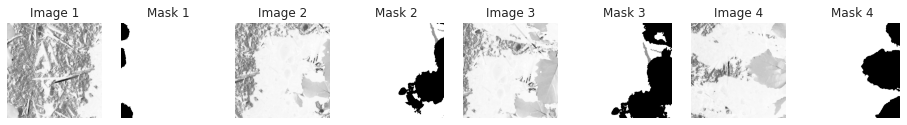

In [18]:
plotImgs(1,8,[data[0,0], target[0]*127, data[1,0], target[1]*127, data[2,0], target[2]*127, data[3,0], target[3]*127], 
    ['Image 1','Mask 1', 'Image 2','Mask 2', 'Image 3','Mask 3', 'Image 4','Mask 4'])

# Model

In this section you will:
- Load the pre-trained weights from torchvision.
- Change the classifier output channels to the number of classes to predict.

Help: you can have a look at `torchvision.models.segmentation.deeplabv3.DeepLabHead`

More information about torchvision deeplabv3 soruce code: [here] (https://pytorch.org/vision/0.12/_modules/torchvision/models/segmentation/deeplabv3.html)

In [19]:
### Load pretrained model
model = models.segmentation.deeplabv3_resnet101(pretrained=True)

### Auxiliaire classifier is modified according to number of class to predict
outputchannels = 3
model.classifier =  DeepLabHead(2048, outputchannels)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/anaconda/envs/azureml_py38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
model.classifier

DeepLabHead(
  (0): ASPP(
    (convs): ModuleList(
      (0): Sequential(
        (0): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): ASPPConv(
        (0): Conv2d(2048, 256, kernel_size=(3, 3), stride=(1, 1), padding=(12, 12), dilation=(12, 12), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): ASPPConv(
        (0): Conv2d(2048, 256, kernel_size=(3, 3), stride=(1, 1), padding=(24, 24), dilation=(24, 24), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (3): ASPPConv(
        (0): Conv2d(2048, 256, kernel_size=(3, 3), stride=(1, 1), padding=(36, 36), dilation=(36, 36), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_

In [21]:
def fit(model, device, dataloader, optimizer, criterion, n_batches, dataset_info):
    """
    For the temporal model (1) Unet + GRU
    Runs 1 training epoch
    n_batches is used to setup the progress bar only. The actual number of batches is defined by the dataloader.
    """
    model.train()
    torch.cuda.empty_cache()

    losses = []
    running_loss = 0.0
    
    # train batch by batch
    progress_bar = tqdm(enumerate(dataloader), total=n_batches)
    cm_cum = np.zeros((dataset_info.n_classes,) * 2).astype('int64')

    for batch_idx, data in progress_bar:

        input, target = data[0], data[1]

        # train batch by batch
        target = target.to(device)
        input = input.type(torch.FloatTensor).to(device)
        
        optimizer.zero_grad()

        result = model(input)
        loss = criterion(result['out'], target.long())

        losses.append(loss.item())
        running_loss += loss.item()
        loss.backward()

        output = torch.argmax(result['out'], axis = 1)

        cm_cum += my_confusion_matrix(target.long().cpu(), output.cpu(), dataset_info.n_classes)
        dict_cm = cm2rates(cm_cum)
        train_metrics = rates2metrics(dict_cm, dataset_info.class_names)
    
        optimizer.step() 

        # print running loss
        progress_bar.set_postfix(
            loss = np.mean(losses), 
            acc = train_metrics['mean']['accuracy'], 
            prec = train_metrics['mean']['precision'], 
            rec = train_metrics['mean']['recall'])
        running_loss = 0.0
        
    avg_loss = np.mean(losses)
    
    return avg_loss, train_metrics

In [22]:
# Set model architecture
# Create model and criterion, and forward + backward pass function
model = model.to(ds_info.device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()### YOUR CODE HERE

n_batches_per_epoch = int(len(dataset.fns) * ds_info.num_patches_per_tile / batch_size)
infer = Inference(model, ds_info)

In [23]:
for i, epoch in enumerate(range(0, num_epochs)):
    
    # shuffle data at every epoch (placed here so that all the workers use the same permutation)
    np.random.shuffle(dataset.fns)

    # forward and backward pass
    avg_loss, metrics_train = fit(
                    model,
                    ds_info.device,
                    dataloader,
                    optimizer,
                    criterion,
                    n_batches_per_epoch,
                    ds_info
                )

    # evaluation (validation) 
    metrics_val, loss_val = infer._get_inference(input_fns_val, target_fns_val, criterion)


    # update and save dictionary containing metrics and checkpoints
    save_dict['val_reports'].append(metrics_val)
    save_dict['val_losses'].append(loss_val)
    save_dict['train_losses'].append(avg_loss)
    save_dict['train_reports'].append(metrics_train)
    save_dict['model_checkpoints'].append(model.state_dict())
    save_dict['optimizer_checkpoints'].append(optimizer.state_dict())
    save_dict['epochs'] = epoch + 1 # number of epochs already computed

    with open(log_fn, 'wb') as f:
        torch.save(save_dict, f)

    # save the last checkpoint in a separate file
    last_checkpoint = {'model': model.state_dict(),
                                    'optimizer': optimizer.state_dict(),
                                    'epoch': epoch,
                                    'model_params': {}} #TEMPORARY
    torch.save(last_checkpoint, model_fn)

  0%|          | 0/10 [00:00<?, ?it/s]/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-gpu-changins/code/Users/aurelie.dejong.agroscope/workshop_Agroscope/utils/eval_utils.py:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:28.)
  y_pred = y_pred[ind]
/mnt/batch/tasks/shared/LS_root/mounts/clusters/compute-gpu-changins/code/Users/aurelie.dejong.agroscope/workshop_Agroscope/utils/eval_utils.py:23: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ../aten/src/ATen/native/IndexingUtils.h:28.)
  y_true = y_true[ind]
100%|██████████| 3/3 [00:11<00:00,  3.84s/it]


# Visualize training logs

In [118]:
# Load training metrics
train_metrics = torch.load(os.getcwd() + '/output/output_metrics.pt')

In [119]:
print('Dictionnary where the logs are saved \n', train_metrics.keys())

print('')
print('Training loss \n', train_metrics['train_losses'])

Dictionnary where the logs are saved 
 dict_keys(['model_checkpoints', 'optimizer_checkpoints', 'train_losses', 'train_reports', 'val_losses', 'val_reports', 'epochs'])

Training loss 
 [0.8924913465976715, 0.7289397478103637, 0.5214517652988434, 0.5388417840003967, 0.4358558416366577]


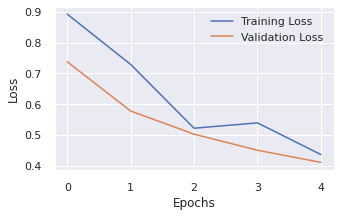

In [120]:
plt_learn = plotLearning(train_metrics, '/output/predictions')
plt_learn.plotLoss()

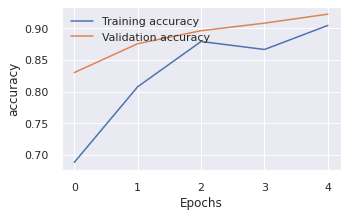

In [121]:
plt_learn.plotMetric('accuracy')

# Inference

In [14]:
save_hard = True
evaluate = True
model_fn = root + '/../../data/oilseed_rape/full_model.pt'
output_dir = root + '/output'
output_img = root + '/output/predictions'

In [37]:
# Load the trained model 
#Load pretrained model
model = models.segmentation.deeplabv3_resnet101(pretrained=True)
#Auxiliaire classifier is modified according to number of class to pre
model.classifier = DeepLabHead(2048, 3)
model.load_state_dict(torch.load(model_fn)['model']) #if only CPU available 
model = model.to(ds_info.device)
model.eval()
print('... model loaded.')

infer = Inference(model, ds_info)

... model loaded.


In [62]:
class_names = ds_info.class_names
dict_attribute = class_names + ['mean', 'overall']
dict_metrics = ['accuracy', 'precision', 'recall', 'f1-score', 'support (%)']
arr = []

In [63]:
input_dir = np.array(glob(root + '/../../data/oilseed_rape/test/*/Images/crop*.*'))   
target_dir = np.array(glob(root +  '/../../data/oilseed_rape/test/*/Masks/*'))

print('Number of images' , len(input_dir), 'matches the number of masks', len(input_dir) == len(target_dir))

Number of images 30 matches the number of masks True


In [65]:
progress_bar = tqdm(enumerate(input_dir), total=len(input_dir))      
print('Start inference...')
        
for n, fn in progress_bar:
                
    filename = fn.split('/')[-1].split('.')[0]
    stream_data = InferenceDataset(ds_info, fn, target_dir[n])
    target = stream_data.target
    output = torch.tensor(infer._infer_sample(stream_data.patches, stream_data.patch_coordinates, target)) #computation of 1 output takes time!
                     
    cm = my_confusion_matrix(target.long().cpu(), output.cpu(), ds_info.n_classes)
    cover = np.array(np.count_nonzero(target.numpy())/np.size(target.numpy())).reshape(1)
    pred = np.array(np.count_nonzero(output.numpy())/np.size(output.numpy())).reshape(1)
    dict = cm2rates(cm)
    results = rates2metrics(dict, class_names)
                
    metrics = []
    cols = []
    for a in dict_attribute:
        for m in dict_metrics:
            metrics.append(results[a][m])
            cols.append(a + ' ' + m)
                        
    arr.append(np.concatenate([np.array(filename).reshape(1), cover, pred, np.array(metrics)]))
    columns = ['Filename', 'Cov', 'Pred'] + cols
            
    #Save results as images
    if save_hard:
        cv2.imwrite(output_img + '/' + filename + '.jpg', output.numpy()*255//(ds_info.n_classes - 1))

  0%|          | 0/30 [00:00<?, ?it/s]/tmp/ipykernel_316631/3802736187.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = torch.tensor(infer._infer_sample(stream_data.patches, stream_data.patch_coordinates, target)) #computation of 1 output takes time!
100%|██████████| 30/30 [02:04<00:00,  4.15s/it]


In [116]:
#Save results per images in a Table .csv
df = pd.DataFrame(columns = columns, data = arr)
df.to_csv(output_dir + '/infer_metrics.csv', index = False)

# Plot inference metrics

In [117]:
df = pd.read_csv(output_dir + '/infer_metrics.csv')
df.head()

,Filename,Cov,Pred,BG accuracy,BG precision,BG recall,BG f1-score,BG support (%),SP accuracy,SP precision,...,mean accuracy,mean precision,mean recall,mean f1-score,mean support (%),overall accuracy,overall precision,overall recall,overall f1-score,overall support (%)
0,cropped_180926_Md_A_M05_3,0.123619,0.141414,0.966749,0.991397,0.971266,0.981229,87.638129,0.953607,0.616680,...,0.964008,0.812164,0.827720,0.806014,100.0,0.966098,0.956486,0.946879,0.948935,100.0
1,cropped_181009_Md_A_M06_3,0.469557,0.453959,0.959860,0.949944,0.977877,0.963708,53.044326,0.949037,0.834775,...,0.955192,0.913050,0.905864,0.909220,100.0,0.957224,0.934162,0.934229,0.933927,100.0
2,cropped_180926_Md_A_M05_3,0.123619,0.141414,0.966749,0.991397,0.971266,0.981229,87.638129,0.953607,0.616680,...,0.964008,0.812164,0.827720,0.806014,100.0,0.966098,0.956486,0.946879,0.948935,100.0
3,cropped_181009_Md_A_M06_3,0.469557,0.453959,0.959860,0.949944,0.977877,0.963708,53.044326,0.949037,0.834775,...,0.955192,0.913050,0.905864,0.909220,100.0,0.957224,0.934162,0.934229,0.933927,100.0
4,cropped_181010_Pr_A_M07_3,0.867293,0.852343,0.957372,0.814844,0.906641,0.858295,13.270686,0.901131,0.940802,...,0.926091,0.875126,0.898747,0.884861,100.0,0.915850,0.896421,0.892271,0.892340,100.0


In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Filename             32 non-null     object 
 1   Cov                  32 non-null     float64
 2   Pred                 32 non-null     float64
 3   BG accuracy          32 non-null     float64
 4   BG precision         32 non-null     float64
 5   BG recall            32 non-null     float64
 6   BG f1-score          32 non-null     float64
 7   BG support (%)       32 non-null     float64
 8   SP accuracy          32 non-null     float64
 9   SP precision         32 non-null     float64
 10  SP recall            32 non-null     float64
 11  SP f1-score          32 non-null     float64
 12  SP support (%)       32 non-null     float64
 13  OSR accuracy         32 non-null     float64
 14  OSR precision        32 non-null     float64
 15  OSR recall           32 non-null     float

In [108]:
df['mean accuracy'].describe()

count    32.000000
mean      0.949494
std       0.030423
min       0.855869
25%       0.947507
50%       0.956697
75%       0.966013
max       0.992989
Name: mean accuracy, dtype: float64